In [1]:
%matplotlib inline
%load_ext autoreload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import time
from datetime import datetime
import scipy.optimize as opt
from sklearn.linear_model import LinearRegression

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
plt.style.use("ggplot")
mpl.pyplot.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams["font.size"] = 13
#mpl.rcParams["font.family"] = 'Osaka'

import sys
sys.path.append('../code/')

from simulation_tx_fee import *
from simulation_fixed_path import make_stats
from hash import *
from plot_path import *

## Reduced form analysis for transaction fee

* See the Appendix in `simulation.ipynb` for the construction of `BTCdata_2018OctDec.csv`.

In [20]:
path = '../data/BTCdata_2.csv'
df_full = pd.read_csv(path, header=0)

# during the period, the block reward was 12.5 BTC
df_full['tx_fee'] = df_full['reward_BTC'] - 12.5
df_full['tx_fee_USD'] = df_full['tx_fee']*df_full['Close']
df_tx = df_full[['height', 'tx_fee', 'tx_fee_USD']]

path = '../data/BTCdata_2018OctDec.csv'
df = pd.read_csv(path, header=0)

df = pd.merge(df, df_tx, on='height')

In [21]:
df.head()

,height,unixtime,price,probability of success /Eh,expected return (USD/Eh),time,adjusted_unixtime,adjusted_blocktime,adjusted_time,tx_fee,tx_fee_USD
0,543835,1538352272,6621.3,0.000033,2.720620,2018-10-01 00:04:32,1538352272,18.633333,2018-10-01 00:04:32,0.122639,812.029743
1,543836,1538352799,6621.3,0.000033,2.711797,2018-10-01 00:13:19,1538352799,8.783333,2018-10-01 00:13:19,0.081705,540.990006
2,543837,1538352841,6621.3,0.000033,2.694189,2018-10-01 00:14:01,1538352841,0.700000,2018-10-01 00:14:01,0.000014,0.090579
3,543838,1538352940,6621.3,0.000033,2.697526,2018-10-01 00:15:40,1538352940,1.650000,2018-10-01 00:15:40,0.015493,102.584595
4,543839,1538353463,6621.3,0.000033,2.714195,2018-10-01 00:24:23,1538353463,8.716667,2018-10-01 00:24:23,0.092831,614.664218


In [25]:
# price data were collected every one hour?
df['price'].unique().shape[0]

2117

In [147]:
price_diff = df['price'].diff().values
temp = 0
for i in range(price_diff.shape[0]):
    if not np.isclose(price_diff[i], 0):
        price_diff[temp:i] = price_diff[i]
        temp = i+1
df['price_diff'] = np.abs(price_diff)

window = 10
df['ave_blocktime'] = df["adjusted_blocktime"].rolling(window).mean()

df.head()

,height,unixtime,price,probability of success /Eh,expected return (USD/Eh),time,adjusted_unixtime,adjusted_blocktime,adjusted_time,tx_fee,tx_fee_USD,price_diff,ave_blocktime
0,543835,1538352272,6621.3,0.000033,2.720620,2018-10-01 00:04:32,1538352272,18.633333,2018-10-01 00:04:32,0.122639,812.029743,NaN,NaN
1,543836,1538352799,6621.3,0.000033,2.711797,2018-10-01 00:13:19,1538352799,8.783333,2018-10-01 00:13:19,0.081705,540.990006,11.31,NaN
2,543837,1538352841,6621.3,0.000033,2.694189,2018-10-01 00:14:01,1538352841,0.700000,2018-10-01 00:14:01,0.000014,0.090579,11.31,NaN
3,543838,1538352940,6621.3,0.000033,2.697526,2018-10-01 00:15:40,1538352940,1.650000,2018-10-01 00:15:40,0.015493,102.584595,11.31,NaN
4,543839,1538353463,6621.3,0.000033,2.714195,2018-10-01 00:24:23,1538353463,8.716667,2018-10-01 00:24:23,0.092831,614.664218,11.31,NaN


Run a regression:
$$
\log \text{Tx fee}_t = \beta_0 + \beta_1 \log \text{Ave. blocktime}_t + \beta_2 \log \text{price}_t + \beta_3 \log \text{price diff}_t + \epsilon_t.
$$

In [148]:
df.shape

(12520, 13)

In [149]:
df = df[df['price_diff']!=0]
df = df[df['tx_fee']!=0]
df = df[df['tx_fee_USD']<10000]
df.shape

(12520, 13)

In [150]:
df_reg = df.dropna()
# df_reg['ave_bt**2'] = df_reg['ave_blocktime']**2
X = df_reg[['ave_blocktime', 'price', 'price_diff']]
Y = df_reg['tx_fee_USD']
reg = LinearRegression().fit(np.log(X), np.log(Y))

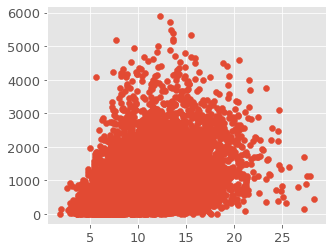

In [151]:
plt.scatter(df_reg['ave_blocktime'], Y)
plt.show()

In [152]:
reg.coef_

array([1.412, 0.651, 0.104])

In [153]:
reg.intercept_

-2.7644610527259497

$$
\hat \beta_0 = -2.76, \hat \beta_1 = 1.412, \hat \beta_2 = 0.651, \hat \beta_3 = 0.104.
$$

## Simulation

* In each period $t$, hash supply $H_t$ is computed given the transaction fee $T_t$.
  - the expected reward is changed to be $(P_t B_t + T_t)W_t$.
  - in the baseline model, it was $P_t B_t W_t$.

In [2]:
path = '../data/BTCdata_presim.csv'
df = pd.read_csv(path)
df['time'] = pd.to_datetime(df['time'])
df = df.rename(columns={'blocktime': 'block_times', 'price': 'prices', 'probability of success /Eh': 'winning_rates'})

In [3]:
generate_simulation_data(num_iter=5000, prev_data=df)
print('DAA-1 and DAA-2 are done.')
generate_simulation_data_DAA0(num_iter=5000, prev_data=df)
print('DAA-0 is done.')
generate_simulation_data_asert(num_iter=5000, prev_data=df)
print('ASERT is done.')

DAA-1 and DAA-2 are done.
DAA-0 is done.
ASERT is done.


In [5]:
dir_sim = '/Volumes/Data/research/BDA/simulation/'
filelist = [dir_sim+'tx_DAA-1_blocktime_ps0_5000obs_T=None.csv',
            dir_sim+'tx_DAA-2_blocktime_ps0_5000obs_T=None.csv',
            dir_sim+'tx_DAA_asert_blocktime_ps0_5000obs_T=None.csv',
            dir_sim+'tx_DAA-0_blocktime_ps0_5000obs.csv'
            ]
df_stats = make_stats(filelist=filelist, dir_sim=dir_sim)

In [6]:
# DAA-0のW(t)はtx feeが決まる前に決まっている
## DAA-1は「まあ多少はマシになっている」くらい
df_stats

,tx_DAA-1_blocktime_ps0_5000obs_T=None.csv,tx_DAA-2_blocktime_ps0_5000obs_T=None.csv,tx_DAA_asert_blocktime_ps0_5000obs_T=None.csv,tx_DAA-0_blocktime_ps0_5000obs.csv
mean,12.097660,10.034037,10.053136,9.759111
std,15.421153,10.218531,10.120275,9.758652
over60,1.000000,1.000000,1.000000,1.000000
over120,0.807400,0.176200,0.112800,0.053800
over180,0.442600,0.001600,0.000400,0.000000
